In [1]:
from __future__ import division

In [2]:
%run util.py

In [3]:
data_dir = "/home/jzh/Dropbox/Research/Anomaly_Detection/MisMatchedTest/"

In [4]:
def KL_est(x, mu, mu1):
    """
    Estimate the relative entropy (K-L divergence)
    x: a sample path of the chain
    mu: the true stationary distribution; an N x N matrix
    """
    mu = np.array(mu)
    N, _ = mu.shape
    assert(N == _)
    
    mu1 = np.array(mu1)
    N1, _ = mu1.shape
    assert(N1 == _)

    # Compute the empirical distribution
    eps = 1e-8
    gama = [0] * N * N
    for j in range(0, N**2):
        gama[j] = (x.count(j)) / (len(x))
        if gama[j] < eps:
            gama[j] = eps
    for j in range(0, N**2):
        gama[j] = gama[j] / sum(gama)  # Normalize the estimated probability law
    gama = np.array(gama)
    gama = np.reshape(gama, (N, N))

    # Compute the Hoeffding relative entropy (K-L divergence)
    d = np.zeros((N, N))
    for i in range(0, N):
        for j in range(0, N):
            d[i, j] = gama[i, j] * (log(gama[i, j] / (sum(gama[i, :]))) - log(mu[i, j] / (sum(mu[i, :]))))
    KL = sum(sum(d))
    
    # Compute the Mismatched divergence
    d = np.zeros((N, N))
    for i in range(0, N):
        for j in range(0, N):
            d[i, j] = gama[i, j] * (log(mu1[i, j] / (sum(mu1[i, :]))) - log(mu[i, j] / (sum(mu[i, :]))))
    KL1 = sum(sum(d))
    
    # Compute the "fake" Hoeffding relative entropy
    d = np.zeros((N, N))
    for i in range(0, N):
        for j in range(0, N):
            d[i, j] = gama[i, j] * (log(gama[i, j]) - log(mu[i, j]))
    KL2 = sum(sum(d))
    
    # Compute the "fake" Mismatched divergence
    d = np.zeros((N, N))
    for i in range(0, N):
        for j in range(0, N):
            d[i, j] = gama[i, j] * (log(mu1[i, j]) - log(mu[i, j]))
    KL3 = sum(sum(d))

    return KL, KL1, KL2, KL3

In [5]:
def wcKLs_testSet(N, n, num_test_sample):
    # mu_0: the initial distribution; 1 x (N**2) 
    # mu: the actual stationary distribution; 1 x (N**2)
    # mu_1: the estimated stationary distribution 
    # P: the new transition matrix (the old transition matrix is Q)
    # G_1: the estimate of the gradient
    # H_1: the estimate of the Hessian

    # P is the ground truth transition matrix
    mu_0, mu, mu_1, P, G_1, H_1, Sigma_1, W_1, rho_1, Chi_1 = ChainGen(N)  

    # PP is a different transition matrix for testing purposes
    mu_0P, muP, mu_1P, PP, G_1P, H_1P, Sigma_1P, W_1P, rho_1P, Chi_1P = ChainGen(N) 
    
    negative_sample = {}
    positive_sample = {}

    # Get sample paths of the Markov chain with length n; 
    # these paths will be the test set
    for idx in range(int(num_test_sample/2)):
        negative_sample[idx] = chain(mu, P, n)
    for idx in range(int(num_test_sample/2)):
        positive_sample[idx] = chain(muP, PP, n)
    
    mu = np.reshape(mu, (N, N))
    muP = np.reshape(muP, (N, N))
    
    # for Hoeffding
    negative_sample_KL_HT = {}
    positive_sample_KL_HT = {}
    
    # for Mismatched
    negative_sample_KL_MM = {}
    positive_sample_KL_MM = {}
    
    # for "fake" Hoeffding
    negative_sample_KL_FHT = {}
    positive_sample_KL_FHT = {}
    
    # for "fake" Mismatched
    negative_sample_KL_FMM = {}
    positive_sample_KL_FMM = {}
    
    # Compute KL divergence values w.r.t. mu for each sample
    for idx in range(int(num_test_sample/2)):
        negative_sample_KL_HT[idx], negative_sample_KL_MM[idx], negative_sample_KL_FHT[idx], \
        negative_sample_KL_FMM[idx] = KL_est(negative_sample[idx], mu, muP)
        
    for idx in range(int(num_test_sample/2)):
        positive_sample_KL_HT[idx], positive_sample_KL_MM[idx], positive_sample_KL_FHT[idx], \
        positive_sample_KL_FMM[idx] = KL_est(positive_sample[idx], mu, muP)
        
    return negative_sample_KL_HT, positive_sample_KL_HT, negative_sample_KL_MM, positive_sample_KL_MM, \
negative_sample_KL_FHT, positive_sample_KL_FHT, negative_sample_KL_FMM, positive_sample_KL_FMM

In [6]:
def roc_data(n, beta, num_test_sample, negative_sample_KL_HT, positive_sample_KL_HT, \
             negative_sample_KL_MM, positive_sample_KL_MM, negative_sample_KL_FHT, positive_sample_KL_FHT, \
            negative_sample_KL_FMM, positive_sample_KL_FMM):
    
    # Get thresholds for Hoeffding's test corresponding to sample length n    
    eta = {}
    key = str(n) + "_" + str(beta)
    eta[key] = beta

    negative_sample_HT = {}
    negative_sample_MM = {}
    negative_sample_FHT = {}
    negative_sample_FMM = {}

    positive_sample_HT = {}
    positive_sample_MM = {}
    positive_sample_FHT = {}
    positive_sample_FMM = {}

    for idx in range(int(num_test_sample/2)):
        if negative_sample_KL_HT[idx] > eta[key]:
            negative_sample_HT[idx] = 1
        else:
            negative_sample_HT[idx] = -1
        if negative_sample_KL_MM[idx] > eta[key]:
            negative_sample_MM[idx] = 1
        else:
            negative_sample_MM[idx] = -1
        if negative_sample_KL_FHT[idx] > eta[key]:
            negative_sample_FHT[idx] = 1
        else:
            negative_sample_FHT[idx] = -1
        if negative_sample_KL_FMM[idx] > eta[key]:
            negative_sample_FMM[idx] = 1
        else:
            negative_sample_FMM[idx] = -1


    for idx in range(int(num_test_sample/2)):
        if positive_sample_KL_HT[idx] > eta[key]:
            positive_sample_HT[idx] = 1
        else:
            positive_sample_HT[idx] = -1
        if positive_sample_KL_MM[idx] > eta[key]:
            positive_sample_MM[idx] = 1
        else:
            positive_sample_MM[idx] = -1
        if positive_sample_KL_FHT[idx] > eta[key]:
            positive_sample_FHT[idx] = 1
        else:
            positive_sample_FHT[idx] = -1
        if positive_sample_KL_FMM[idx] > eta[key]:
            positive_sample_FMM[idx] = 1
        else:
            positive_sample_FMM[idx] = -1
            

    TP_HT = count_one(positive_sample_HT.values())[0]
    FP_HT = count_one(negative_sample_HT.values())[0]
    TN_HT = count_one(negative_sample_HT.values())[1]
    FN_HT = count_one(positive_sample_HT.values())[1]
    TPR_HT = TP_HT / (TP_HT + FN_HT)
    FPR_HT = FP_HT / (FP_HT + TN_HT)

    TP_MM = count_one(positive_sample_MM.values())[0]
    FP_MM = count_one(negative_sample_MM.values())[0]
    TN_MM = count_one(negative_sample_MM.values())[1]
    FN_MM = count_one(positive_sample_MM.values())[1]
    TPR_MM = TP_MM / (TP_MM + FN_MM)
    FPR_MM = FP_MM / (FP_MM + TN_MM)
    
    TP_FHT = count_one(positive_sample_FHT.values())[0]
    FP_FHT = count_one(negative_sample_FHT.values())[0]
    TN_FHT = count_one(negative_sample_FHT.values())[1]
    FN_FHT = count_one(positive_sample_FHT.values())[1]
    TPR_FHT = TP_FHT / (TP_FHT + FN_FHT)
    FPR_FHT = FP_FHT / (FP_FHT + TN_FHT)
    
    TP_FMM = count_one(positive_sample_FMM.values())[0]
    FP_FMM = count_one(negative_sample_FMM.values())[0]
    TN_FMM = count_one(negative_sample_FMM.values())[1]
    FN_FMM = count_one(positive_sample_FMM.values())[1]
    TPR_FMM = TP_FMM / (TP_FMM + FN_FMM)
    FPR_FMM = FP_FMM / (FP_FMM + TN_FMM)
    
    data_HT = {"TPR": TPR_HT, "FPR":FPR_HT}
    data_MM = {"TPR": TPR_MM, "FPR":FPR_MM}
    data_FHT = {"TPR": TPR_FHT, "FPR":FPR_FHT}
    data_FMM = {"TPR": TPR_FMM, "FPR":FPR_FMM}
    
    return data_HT, data_MM, data_FHT, data_FMM

In [7]:
N = 3
n = 20
num_test_sample = 12000

beta_list = list(np.arange(-2, 2, 0.0001)[1:-1])

In [8]:
# beta_list

In [9]:
negative_sample_KL_HT, positive_sample_KL_HT, negative_sample_KL_MM, positive_sample_KL_MM, \
negative_sample_KL_FHT, positive_sample_KL_FHT, negative_sample_KL_FMM, positive_sample_KL_FMM = \
wcKLs_testSet(N, n, num_test_sample)

<string>:332: RuntimeWarning: covariance is not positive-semidefinite.


In [10]:
# negative_sample_KL_MM

In [11]:
roc_data_HT = {}
roc_data_MM = {}
roc_data_FHT = {}
roc_data_FMM = {}

for beta in beta_list:
    roc_data_HT[beta], roc_data_MM[beta], roc_data_FHT[beta], roc_data_FMM[beta] = \
    roc_data(n, beta, num_test_sample, negative_sample_KL_HT, positive_sample_KL_HT, \
             negative_sample_KL_MM, positive_sample_KL_MM, negative_sample_KL_FHT, positive_sample_KL_FHT, \
            negative_sample_KL_FMM, positive_sample_KL_FMM)

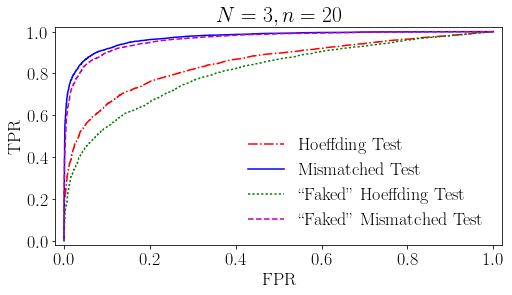

In [12]:
import matplotlib.pyplot as plt
import pylab
from pylab import *
%matplotlib inline  
import itertools 


plt.figure(figsize=(8, 4))

font = {"family" : "normal",
        "weight" : "normal",
        "size"   : 18}

matplotlib.rc('font', **font)

from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# ## for Palatino and other serif fonts use:
# #rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

roc_HT_re, = plt.plot([roc_data_HT[beta]["FPR"] for beta in beta_list], \
                     [roc_data_HT[beta]["TPR"] for beta in beta_list], "r-.", linewidth=1.5, markersize=5, \
                        markerfacecolor="None", markeredgecolor="r", markeredgewidth=1)

roc_MM_re, = plt.plot([roc_data_MM[beta]["FPR"] for beta in beta_list], \
                     [roc_data_MM[beta]["TPR"] for beta in beta_list], "b-", linewidth=1.5, markersize=5, \
                        markerfacecolor="None", markeredgecolor="b", markeredgewidth=1)

roc_FHT_re, = plt.plot([roc_data_FHT[beta]["FPR"] for beta in beta_list], \
                     [roc_data_FHT[beta]["TPR"] for beta in beta_list], "g:", linewidth=1.5, markersize=5, \
                        markerfacecolor="None", markeredgecolor="g", markeredgewidth=1)

roc_FMM_re, = plt.plot([roc_data_FMM[beta]["FPR"] for beta in beta_list], \
                     [roc_data_FMM[beta]["TPR"] for beta in beta_list], "m--", linewidth=1.5, markersize=5, \
                        markerfacecolor="None", markeredgecolor="b", markeredgewidth=1)

legend_list = [r"Hoeffding Test", r"Mismatched Test", r"``Faked'' Hoeffding Test", r"``Faked'' Mismatched Test"]

# legend(loc=0, fancybox="true", ncol=2, mode="expand", borderaxespad=0.2) 

plt.legend([roc_HT_re, roc_MM_re, roc_FHT_re, roc_FMM_re,], legend_list, loc=4, numpoints=1, \
           fancybox="false", frameon=False) 
plt.title(r"$N = %s, n = %s$"%(N, n))
# plt.xticks(N_list)

pylab.xlim(-0.02, 1.02)
pylab.ylim(-0.02, 1.02)

plt.xlabel("FPR")
plt.ylabel("TPR")
# plt.grid()

savefig(data_dir + "ROC_N_%s_n_%s_uni_ano_PL.eps"%(N, n), dpi=300, bbox_inches="tight")

plt.show()